In [ ]:
#!pip install -r requirements.txt

# Pruning Distillation Pipeline

- Comparison of model performance for **sentiment-analysis**
- **BERT-Model** for pruning and as teacher
- **Tiny-BERT** as comparision
- **Training** pruned model and Tiny-BERT **with and without distillation**
- **SST-2** dataset for text-classification

# Help Functions

### Training Evaluation metrics

In [4]:
from evaluate import load
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the accuracy metric
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

all_metrics = []

def compute_metrics(eval_pred):
    global all_metrics

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="macro", zero_division=0)
    recall = recall_score(labels, predictions, average="macro", zero_division=0)
    f1 = f1_score(labels, predictions, average="macro", zero_division=0)
    #return {
    #    "accuracy": acc,#["accuracy"],
    #    "precision": precision,#["precision"],
    #    "recall": recall,#["recall"],
    #    "f1": f1,#["f1"]
    #}
    # Save the metrics in the global list (add a dictionary with metrics)
    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    # Append the metrics to the list
    all_metrics.append(metrics)
    return metrics

### Final Model Evaluation

Configure evalutation to be text-classification and modify it for the sst-2 dataset.

In [3]:
from evaluate import evaluator
from transformers import pipeline

task_evaluator = evaluator("text-classification")

def evaluate_model(model, tokenizer, data):
    model_eval = task_evaluator.compute(
        model_or_pipeline=model,
        tokenizer=tokenizer,
        data=data,
        input_column="sentence",
        label_column="labels",
        #label_mapping={"LABEL_0": 0, "LABEL_1": 1}
        label_mapping={"negative": 0, "positive": 1},
    )

    return model_eval

### Training Visualization

In [5]:
import matplotlib.pyplot as plt

def plot_train_eval_metrics(trainer, all_metrics):    
    # Get the training and validation losses
    train_losses = trainer.state.log_history

    # Extracting training and validation loss
    train_loss_values = [log['loss'] for log in train_losses if 'loss' in log]
    eval_loss_values = [log['eval_loss'] for log in train_losses if 'eval_loss' in log]

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Create two subplots side by side

    # Plot the loss on the first axis (Train and Validation Loss)
    axes[0].plot(train_loss_values, label='Train Loss', color='tab:blue')
    axes[0].plot(eval_loss_values, label='Validation Loss', color='tab:orange')

    # Mark the best epoch for train and validation losses (minimum loss)
    best_train_epoch = train_loss_values.index(min(train_loss_values))
    best_eval_epoch = eval_loss_values.index(min(eval_loss_values))

    # Mark the best epochs with points
    axes[0].scatter(best_train_epoch, train_loss_values[best_train_epoch], color='tab:blue', zorder=5)
    axes[0].scatter(best_eval_epoch, eval_loss_values[best_eval_epoch], color='tab:orange', zorder=5)

    axes[0].set_title('Train and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Define the plotting function for all metrics on one graph (with best epoch marked)
    def plot_all_metrics_on_one_graph(all_metrics, ax):
        # Extract each metric from the all_metrics list
        accuracy = [metrics["accuracy"] for metrics in all_metrics]
        precision = [metrics["precision"] for metrics in all_metrics]
        recall = [metrics["recall"] for metrics in all_metrics]
        f1 = [metrics["f1"] for metrics in all_metrics]

        # Plot all metrics on the same axis without points (just lines)
        ax.plot(accuracy, label='Accuracy', color='tab:blue')
        ax.plot(precision, label='Precision', color='tab:green')
        ax.plot(recall, label='Recall', color='tab:red')
        ax.plot(f1, label='F1 Score', color='tab:purple')

        # Mark the best epoch for each metric with a point (max value)
        best_accuracy_epoch = accuracy.index(max(accuracy))
        best_precision_epoch = precision.index(max(precision))
        best_recall_epoch = recall.index(max(recall))
        best_f1_epoch = f1.index(max(f1))

        # Mark the best epochs with points
        ax.scatter(best_accuracy_epoch, accuracy[best_accuracy_epoch], color='tab:blue', zorder=5)
        ax.scatter(best_precision_epoch, precision[best_precision_epoch], color='tab:green', zorder=5)
        ax.scatter(best_recall_epoch, recall[best_recall_epoch], color='tab:red', zorder=5)
        ax.scatter(best_f1_epoch, f1[best_f1_epoch], color='tab:purple', zorder=5)

        # Add title and labels
        ax.set_title('Evaluation Metrics Over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Metric Value')

        # Show legend
        ax.legend()

    # Create the second plot for all metrics with best epochs marked
    plot_all_metrics_on_one_graph(all_metrics, axes[1])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

### Load Local model

In [2]:
from transformers import BertConfig

def load_local_model(model_path: str):
    # Load the configuration for the model
    model_config = BertConfig.from_pretrained(f"{model_path}/config.json")

    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        config=model_config,
        local_files_only=True,
        ignore_mismatched_sizes=True,
        )
    
    return model

### Load Dataset and Tokenizer

This code block sets up the SST-2 dataset for use with a BERT-based model. It begins by loading the tokenizer for the textattack/bert-base-uncased-SST-2 model and **loading the SST-2 dataset** from local storage. A preprocessing function is defined to **tokenize the sentences** with truncation to a maximum length of 512 tokens. We tokenize the dataset to convert text into numerical representations that a model can understand and process for training. Finally, the training dataset is shuffled with a fixed seed to ensure reproducibility.

In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset, load_from_disk

#main_model = "google-bert/bert-base-uncased"
main_model = "textattack/bert-base-uncased-SST-2"
tiny_bert_id = "google/bert_uncased_L-2_H-128_A-2"
teacher_id = main_model # The main model will also be our teacher for model distillation

tokenizer = AutoTokenizer.from_pretrained(main_model) # We use the same tokenizer throughout all models. It becomes more important for distilliation
#tokenizer.save_pretrained('./tokenizer')
#tokenizer = AutoTokenizer.from_pretrained('./tokenizer')

dataset_id="glue"
dataset_config="sst2"

dataset = load_dataset(dataset_id,dataset_config)
#local_dataset_path = "./sst2"  # save dataset locally for showcase purposes
#dataset.save_to_disk(local_dataset_path)
#dataset = load_from_disk(local_dataset_path)

dataset

def process(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, max_length=512
    )
    return tokenized_inputs

tokenized_datasets = dataset.map(process, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label","labels")
tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=42)#.select(range(1000))


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

### Load External BERT Model

In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Warning
import torch
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, BertConfig
from huggingface_hub import HfFolder

# create label2id, id2label dicts for nice outputs for the model
labels = tokenized_datasets["train"].features["labels"].names
#labels = ["negative", "positive"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

def load_external_model(model_id: str, set_size=False):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    
    if set_size==True:
        config = BertConfig.from_pretrained(model_id)
        config.hidden_size = 384
        config.intermediate_size = 1536
        model.config = config
    
    return model

# Structural Pruning

In the following, the **Attention Heads** and the **intermediate layers** of the original BERT model are structurally pruned based on the **smallest magnitude weights**. All Attention layers are retained. The **attention layers** are reduced **from 768 to 384** and the **intermediate-size** is reduced **from 3072 to 1536**. In addition, the pooling and classification layers are configured for training. In total, the number of parameters is **reduced from 109M to 33M**, a reduction of about **70%**.

This pruning is based on the work of https://github.com/VainF/Torch-Pruning.

In [8]:
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention, BertPooler
import torch_pruning as tp

pruned_model = load_external_model(main_model, set_size=True)
#pruned_model = load_local_model("./teacher_model") # For Showcase purposes

hf_inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
example_inputs = {'input_ids': hf_inputs['input_ids'], 'token_type_ids': hf_inputs['token_type_ids'], 'attention_mask': hf_inputs['attention_mask']}

imp = tp.importance.MagnitudeImportance(p=2, group_reduction="mean")
base_macs, base_params = tp.utils.count_ops_and_params(pruned_model, example_inputs)
num_heads = {}

# All heads should be pruned simultaneously, so we group channels by head.
for m in pruned_model.modules():
    if isinstance(m, BertSelfAttention):
        num_heads[m.query] = m.num_attention_heads
        num_heads[m.key] = m.num_attention_heads
        num_heads[m.value] = m.num_attention_heads

# https://github.com/VainF/Torch-Pruning/blob/master/torch_pruning/pruner/algorithms/metapruner.py
pruner = tp.pruner.MetaPruner(
    pruned_model, 
    example_inputs, 
    global_pruning=False, # If False, a uniform pruning ratio will be assigned to different layers.
    importance=imp, # importance criterion for parameter selection
    iterative_steps=1, # the number of iterations to achieve target pruning ratio
    pruning_ratio=0.5,
    num_heads=num_heads,
    prune_head_dims=False,
    prune_num_heads=True,
    head_pruning_ratio=0.5,
    output_transform=lambda out: out.logits.sum(),
    ignored_layers=[pruned_model.bert.pooler],
)

for g in pruner.step(interactive=True):
    #print(g)
    g.prune()

# Modify the attention head size and all head size after pruning
for m in pruned_model.modules():
    if isinstance(m, BertSelfAttention):
        #print("Num heads: %d, head size: %d =>"%(m.num_attention_heads, m.attention_head_size))
        m.num_attention_heads = pruner.num_heads[m.query]
        m.attention_head_size = m.query.out_features // m.num_attention_heads
        m.all_head_size = m.query.out_features
        #print("Num heads: %d, head size: %d"%(m.num_attention_heads, m.attention_head_size))
        #print()
        
for m in pruned_model.modules():
    if isinstance(m, BertPooler):
        m.dense = torch.nn.Linear(384, 384)  # Modify the pooler layer to use 384 input/output features
        print(f"Modified pooler dense layer to in_features=384, out_features=384")

for m in pruned_model.modules():
    if isinstance(m, BertForSequenceClassification):
        m.classifier = torch.nn.Linear(384, 2)  # Modify classifier to match the new pooler output size
        print(f"Modified classifier output to {m.classifier.out_features}")

#print(pruned_model)

test_output = pruned_model(**example_inputs)
pruned_macs, pruned_params = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print("Base MACs: %f M, Pruned MACs: %f M"%(base_macs/1e6, pruned_macs/1e6))
print("Base Params: %f M, Pruned Params: %f M"%(base_params/1e6, pruned_params/1e6))

# Calculate the difference in parameters before and after pruning
params_diff = base_params - pruned_params

# Print the comparison
print("Difference in Params: %f M"%(params_diff/1e6))

Warning! No positional inputs found for a module, assuming batch size is 1.
Modified pooler dense layer to in_features=384, out_features=384
Modified classifier output to 2
Warning! No positional inputs found for a module, assuming batch size is 1.
Base MACs: 680.459522 M, Pruned MACs: 170.212994 M
Base Params: 109.483778 M, Pruned Params: 33.360770 M
Difference in Params: 76.123008 M


![image1](./model_comparison_marked.png)

# Training Variables

In [12]:
# Folder for checkpoints and logs during training
output_dir = "training_temp"
num_train_epochs = 10
per_device_train_batch_size = 64
per_device_eval_batch_size = 64
fp16=False
learning_rate=3e-5
seed=33
logging_dir=f'{output_dir}/logs'
logging_strategy="epoch"
evaluation_strategy="epoch"
save_strategy="epoch"
save_total_limit=3 # How many tempory checkpoints should be saved
load_best_model_at_end=True
metric_for_best_model="accuracy"
greater_is_better=True,
#metric_for_best_model="eval_loss",  # Monitor validation loss
#greater_is_better=False, # For validation loss, less is better
push_to_hub=False
weight_decay=0.5 # Not set in the training examples
early_stopping_patience=3

# Basic Training

This is a basic training procedure used to compare normally trained models with the distilled models from below. It is done for both the pruned and the Tiny-BERT model.

In [13]:
from transformers import AutoTokenizer, BertModel, BertForSequenceClassification, EarlyStoppingCallback, BertConfig, AutoModel
import torch
from transformers.models.bert.modeling_bert import BertSelfAttention, BertPooler
import torch_pruning as tp
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    fp16=fp16,
    learning_rate=learning_rate,
    seed=seed,
    # logging & evaluation strategies
    logging_dir=logging_dir,
    logging_strategy=logging_strategy, # to get more information to TB
    evaluation_strategy=evaluation_strategy,
    save_strategy=save_strategy,
    save_total_limit=save_total_limit,
    load_best_model_at_end=load_best_model_at_end,
    metric_for_best_model=metric_for_best_model,
    greater_is_better=greater_is_better,
    push_to_hub=push_to_hub,
    #weight_decay=weight_decay
)

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

early_stopping = EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)

# One Trainer for the pruned_model
prune_trainer = Trainer (
    pruned_model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

tiny_bert_model = load_external_model(tiny_bert_id)

# One Trainer for the tiny_bert_model
tiny_bert_trainer = Trainer (
    tiny_bert_model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)

/Users/christophknaden/venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_1144/2656574652.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  prune_trainer = Trainer (
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_1144/2656574652.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_clas

#### Save and Load Pruned Model

In [10]:
# Pruned model path without training
pruned_model_path = "./pruned_model"

In [11]:
# Save pruned model without training, as base for distillation
prune_trainer.save_model(pruned_model_path)

In [11]:
pruned_model_loaded = load_local_model(pruned_model_path)

## Train pruned model & Tiny Bert conventional way

#### Train Pruned Model

In [13]:
# Train a pruned model the conventional way
prune_trainer.train()

# Save metrics
all_metrics_pruned = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.382000,0.442660,0.806193,0.806462,0.805854,0.805978
2,0.251200,0.449122,0.817661,0.818353,0.818083,0.817649
3,0.202800,0.509491,0.818807,0.819157,0.818452,0.818593
4,0.168800,0.555293,0.823394,0.823567,0.823125,0.823237
5,0.147200,0.573982,0.819954,0.819926,0.819830,0.819869
6,0.127700,0.597555,0.818807,0.819157,0.818452,0.818593
7,0.113300,0.707349,0.831422,0.831862,0.831050,0.831209
8,0.100500,0.693609,0.824541,0.824490,0.824461,0.824475
9,0.090800,0.734165,0.825688,0.825790,0.825461,0.825556
10,0.083400,0.723299,0.823394,0.823433,0.823209,0.823282


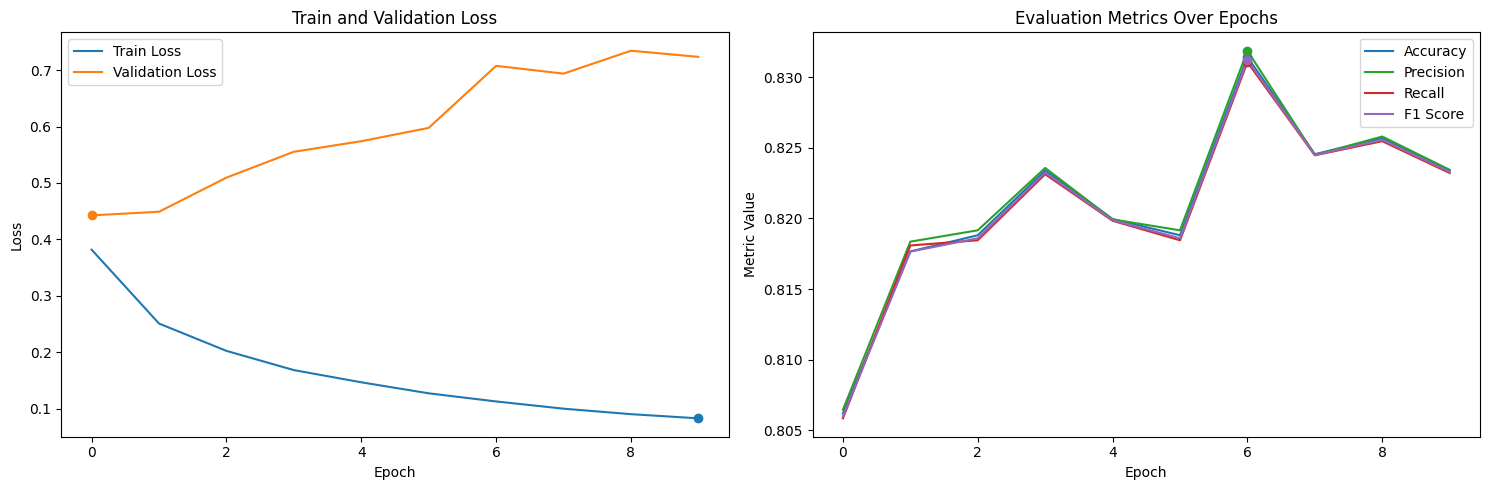

In [14]:
plot_train_eval_metrics(prune_trainer, all_metrics_pruned)

#### Save and Load Pruned Model

In [12]:
# Pruned model path with training
pruned_model_trained_path = "./pruned_model_trained"

In [16]:
# Save pruned model with training
prune_trainer.save_model(pruned_model_trained_path)

In [13]:
pruned_model_trained = load_local_model(pruned_model_trained_path)

#### Train Tiny-BERT

In [18]:
# Train a pruned model the conventional way
tiny_bert_trainer.train()

# Save metrics
all_metrics_tiny_bert = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.492300,0.454080,0.797018,0.797686,0.797434,0.797005
2,0.348900,0.438246,0.810780,0.811611,0.811242,0.810760
3,0.296600,0.438716,0.808486,0.808673,0.808190,0.808302
4,0.266800,0.440674,0.821101,0.821480,0.821420,0.821100
5,0.243400,0.446790,0.831422,0.831375,0.831470,0.831395
6,0.230200,0.450895,0.822248,0.822575,0.822546,0.822247
7,0.216500,0.469203,0.827982,0.828261,0.828261,0.827982
8,0.211000,0.475074,0.823394,0.823394,0.823503,0.823380


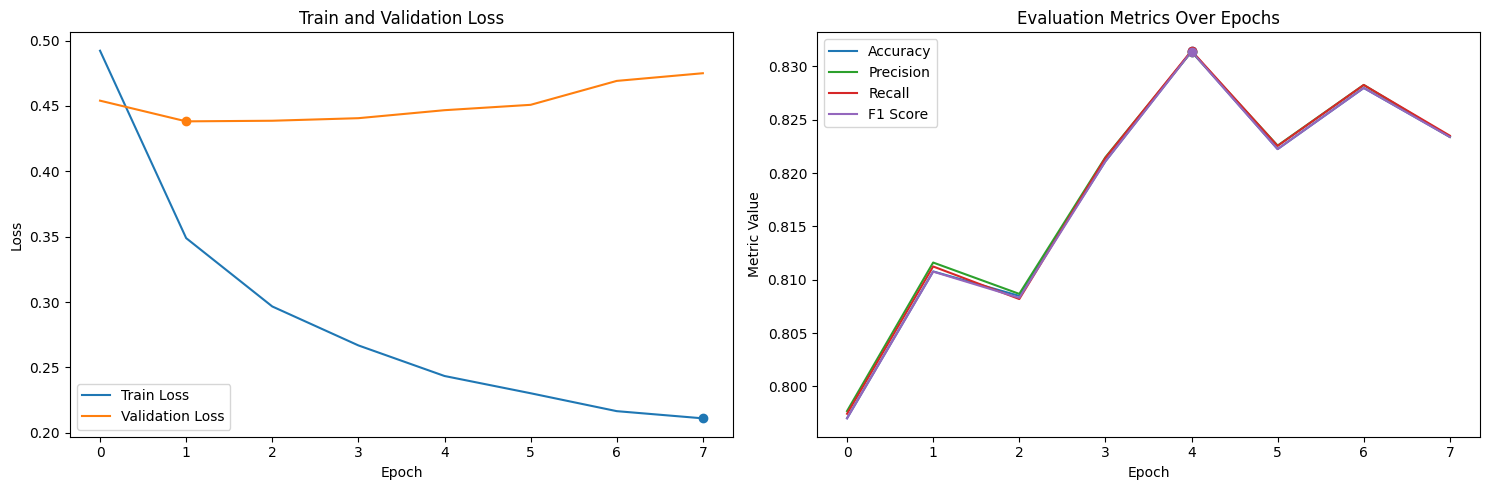

In [19]:
plot_train_eval_metrics(tiny_bert_trainer, all_metrics_tiny_bert)

#### Save and Load Tiny-BERT Model

In [14]:
tiny_bert_model_trained_path = "./tiny_bert_model_trained"

In [21]:
tiny_bert_trainer.save_model(tiny_bert_model_trained_path)

In [15]:
tiny_bert_model_trained = load_local_model(tiny_bert_model_trained_path)

# Knowledge Distillation

The following part contains the training procedure of the **task-specific distillation training**. The **teacher** model in both cases is the original **BERT-Model** and the **student** models are each the untrained **pruned** and **Tiny-BERT** models. The teacher model is **task-specific** because it was pre-trained and fine-tuned on the **SST-2** dataset.

The Knowledge Destillation training is based on the work of https://github.com/philschmid/knowledge-distillation-transformers-pytorch-sagemaker/tree/master.

In [17]:
%%writefile custom_args.py
# Write class to external file to work
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

Overwriting custom_args.py


## Distillation Trainer

This code defines a custom **DistillationTrainer** for training a student model with knowledge distillation from a teacher model. The custom **loss function** combines two components: the **student loss** (based on ground truth labels) and the **teacher loss** (calculated using Kullback-Leibler Divergence between the softened predictions of the student and teacher). These two losses are weighted by the hyperparameter alpha, allowing the **student to learn from both the ground truth and the teacher's knowledge**.

In [14]:
import importlib
import custom_args
importlib.reload(custom_args)
from custom_args import DistillationTrainingArguments
from transformers import TrainingArguments, Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, accelerator=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model

        self.accelerator = accelerator if accelerator else Accelerator()
        # Place teacher model on the correct device using the accelerator
        self.teacher = self.accelerator.prepare(self.teacher)
        
        # place teacher on same device as student
        #self._move_model_to_device(self.teacher,self.model.device)
        self.teacher.eval()

def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    # compute student original target loss
    outputs_student = model(**inputs)
    student_loss = outputs_student.loss

    # compute teacher output
    with torch.no_grad():
        outputs_teacher = self.teacher(**inputs)

    # assert size
    assert outputs_student.logits.size() == outputs_teacher.logits.size()

    # Soften probabilities and compute distillation loss
    loss_function = nn.KLDivLoss(reduction="batchmean")
    loss_logits = (loss_function(
        F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
        F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1)) * (self.args.temperature ** 2))

    # Return weighted student loss from both teacher and original target
    loss = self.args.alpha * student_loss + (1. - self.args.alpha) * loss_logits
    return (loss, outputs_student) if return_outputs else loss


### Hyperparameter Definition, Model Loading

In [19]:
from transformers import DataCollatorWithPadding
from huggingface_hub import HfFolder

# define training args
training_args = DistillationTrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    fp16=fp16,
    learning_rate=learning_rate,
    seed=seed,
    # logging & evaluation strategies
    logging_dir=f"{output_dir}/logs",
    logging_strategy=logging_strategy,
    evaluation_strategy=evaluation_strategy,
    save_strategy=save_strategy,
    save_total_limit=save_total_limit,
    load_best_model_at_end=load_best_model_at_end,
    metric_for_best_model=metric_for_best_model,
    greater_is_better=greater_is_better,
    # special parameters for huggingface
    report_to="tensorboard",
    # push to hub parameters
    push_to_hub=push_to_hub,
    hub_strategy="every_save",
    hub_model_id=repo_name,
    hub_token=HfFolder.get_token(),
    # distilation parameters
    alpha=0.5,
    temperature=4.0
    )

# define data_collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

early_stopping = EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)

teacher_model = load_external_model(teacher_id)

In [20]:
from accelerate import Accelerator
accelerator = Accelerator(cpu=True)

## Train pruned model & Tiny Bert with Distillation

In [21]:
distilliation_trainer_pruned = DistillationTrainer(
    pruned_model_loaded,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator,
    callbacks=[early_stopping]
)

tiny_bert_model = load_external_model(tiny_bert_id)

distilliation_trainer_tiny_bert = DistillationTrainer(
    tiny_bert_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator,
    callbacks=[early_stopping]
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_1316/239319299.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Train Pruned Model

In [22]:
distilliation_trainer_pruned.train()

# save metrics
all_metrics_pruned_distilled = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.393600,0.442451,0.795872,0.803494,0.794371,0.793960
2,0.256400,0.464377,0.827982,0.829701,0.828639,0.827908
3,0.207600,0.470497,0.825688,0.828104,0.824872,0.825066
4,0.177100,0.501656,0.822248,0.823632,0.822840,0.822195
5,0.151200,0.615447,0.813073,0.814560,0.812400,0.812574


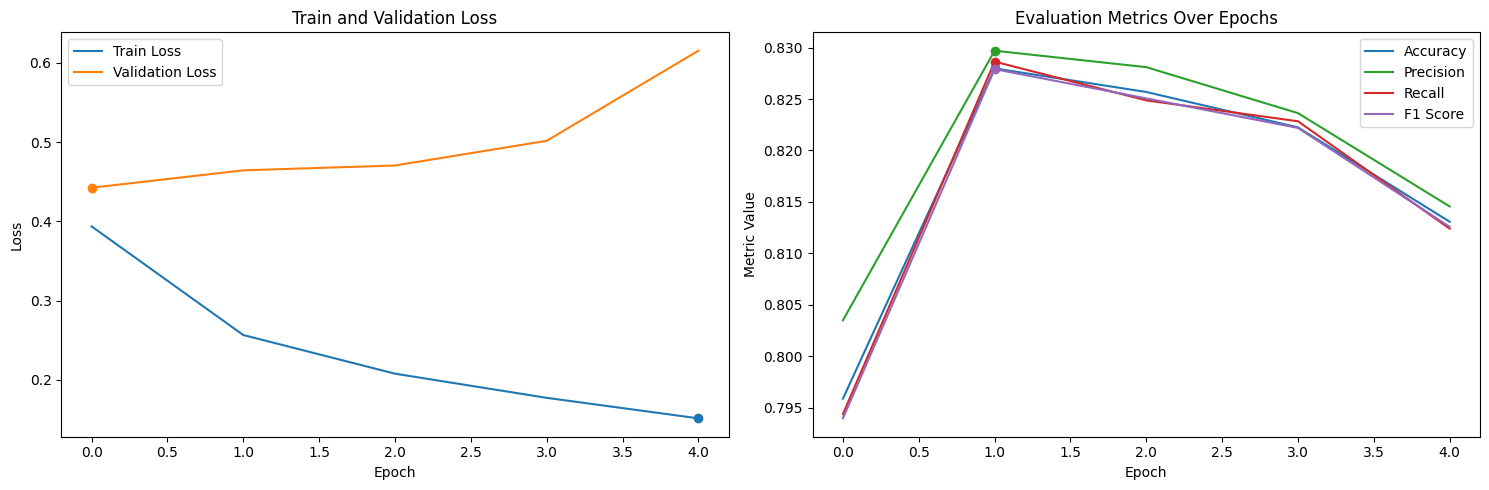

In [23]:
plot_train_eval_metrics(distilliation_trainer_pruned, all_metrics_pruned_distilled)

#### Save and Load Pruned Model

In [24]:
pruned_distilled_model_path = "./pruned_distilled_model"

In [32]:
distilliation_trainer_pruned.save_model(pruned_distilled_model_path)

events.out.tfevents.1735224488.AirvonChristoph.fritz.box.1472.2:   0%|          | 0.00/8.95k [00:00<?, ?B/s]

In [25]:
pruned_distilled_model = load_local_model(pruned_distilled_model_path)

#### Train Tiny-BERT

In [38]:
distilliation_trainer_tiny_bert.train()

all_metrics_tiny_bert_distilled = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.492100,0.459564,0.784404,0.786621,0.785173,0.784240
2,0.349600,0.437676,0.806193,0.809198,0.807075,0.805978
3,0.296300,0.445060,0.813073,0.813078,0.812905,0.812965
4,0.263300,0.454786,0.816514,0.816452,0.816452,0.816452
5,0.243100,0.463318,0.819954,0.820800,0.820420,0.819935
6,0.230100,0.458611,0.824541,0.824772,0.824798,0.824541
7,0.216900,0.478366,0.825688,0.825653,0.825756,0.825665
8,0.211200,0.481399,0.825688,0.825623,0.825671,0.825643
9,0.203300,0.490077,0.825688,0.825737,0.825840,0.825680
10,0.201300,0.495073,0.823394,0.823506,0.823588,0.823391


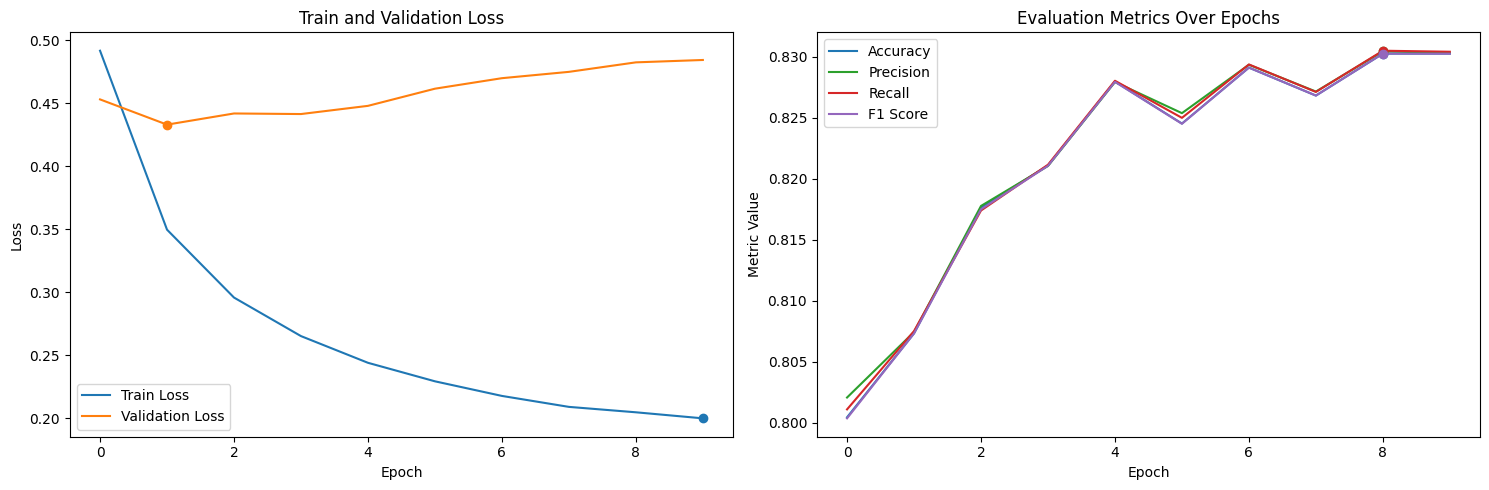

In [35]:
plot_train_eval_metrics(distilliation_trainer_tiny_bert, all_metrics_tiny_bert_distilled)

#### Save and Load Tiny-BERT

In [28]:
tiny_bert_distilled_model_path = "./tiny_bert_distilled_model"

In [88]:
distilliation_trainer_tiny_bert.save_model(tiny_bert_distilled_model_path)

No files have been modified since last commit. Skipping to prevent empty commit.


In [29]:
tiny_bert_distilled_model = load_local_model(tiny_bert_distilled_model_path)

## Hyperparameter Search for Distillation parameter `alpha` & `temperature` with optuna

To **optimize the parameter search** for `alpha` & `temperature`, optuna can help to find them. Since it is a bit **random** and the more time and resources you have, the better your results will be, this is just an example of what is possible.

In [33]:
n_trials=2
direction="maximize"

def hp_space(trial):
    return {
      "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
      "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-3 ,log=True),
      "alpha": trial.suggest_float("alpha", 0, 1),
      "temperature": trial.suggest_int("temperature", 2, 30),
      }

In [34]:
def student_init_pruned_distilled():
    return load_local_model(pruned_distilled_model_path) # We don't want to override the model during hyperparameter exploration

def student_init_tiny_bert_distilled():
    return load_local_model(tiny_bert_distilled_model_path) # We don't want to override the model during hyperparameter exploration

pruned_distilled_trainer_exploration = DistillationTrainer(
    model_init=student_init_pruned_distilled,
    args=training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],#.select(range(1000)),
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator
)

tiny_bert_distilled_trainer_exploration = DistillationTrainer(
    model_init=student_init_tiny_bert_distilled,
    args=training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    accelerator=accelerator
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_1316/239319299.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


#### Train Pruned Model

In [35]:
best_run_pruned = pruned_distilled_trainer_exploration.hyperparameter_search(
    n_trials=n_trials,
    direction=direction,
    hp_space=hp_space
)
print(best_run_pruned)

[I 2025-01-02 21:22:32,113] A new study created in memory with name: no-name-7800ae04-1138-4899-a5d1-7be6eadb6a44


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.312800,0.461728,0.799312,0.805328,0.800570,0.798727
2,0.246200,0.487985,0.807339,0.807275,0.807275,0.807275
3,0.190900,0.644972,0.798165,0.798097,0.798097,0.798097
4,0.158800,0.650977,0.801606,0.802820,0.800970,0.801122


[I 2025-01-02 21:51:40,868] Trial 0 finished with value: 3.2065182105075087 and parameters: {'num_train_epochs': 4, 'learning_rate': 0.00016485875424708388, 'alpha': 0.6982580549628326, 'temperature': 25}. Best is trial 0 with value: 3.2065182105075087.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.361100,0.537461,0.786697,0.811164,0.789235,0.783374
2,0.385700,0.619289,0.758028,0.761294,0.756915,0.756676
3,0.401200,0.695895,0.704128,0.738443,0.700535,0.690653
4,0.459100,0.697286,0.705275,0.746727,0.701408,0.689761
5,0.681700,0.696061,0.509174,0.254587,0.500000,0.337386
6,0.687200,0.697124,0.509174,0.254587,0.500000,0.337386


[I 2025-01-02 22:38:40,048] Trial 1 finished with value: 1.6011474861269903 and parameters: {'num_train_epochs': 6, 'learning_rate': 0.0002024953309846314, 'alpha': 0.08499228973553907, 'temperature': 22}. Best is trial 0 with value: 3.2065182105075087.


BestRun(run_id='0', objective=3.2065182105075087, hyperparameters={'num_train_epochs': 4, 'learning_rate': 0.00016485875424708388, 'alpha': 0.6982580549628326, 'temperature': 25}, run_summary=None)


In [37]:
# overwrite initial hyperparameters with from the best_run
for k,v in best_run_pruned.hyperparameters.items():
    setattr(training_args, k, v)

# Create a new Trainer with optimal parameters
pruned_opt_distillation_trainer = DistillationTrainer(
    pruned_distilled_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_1316/239319299.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [38]:
all_metrics = []

pruned_opt_distillation_trainer.train()

all_metrics_pruned_opt_distillation = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.315100,0.534472,0.802752,0.804932,0.801928,0.802048
2,0.238000,0.515009,0.805046,0.808338,0.804054,0.804118
3,0.161200,0.532352,0.808486,0.809940,0.807811,0.807975
4,0.112600,0.624762,0.811927,0.811954,0.811737,0.811807


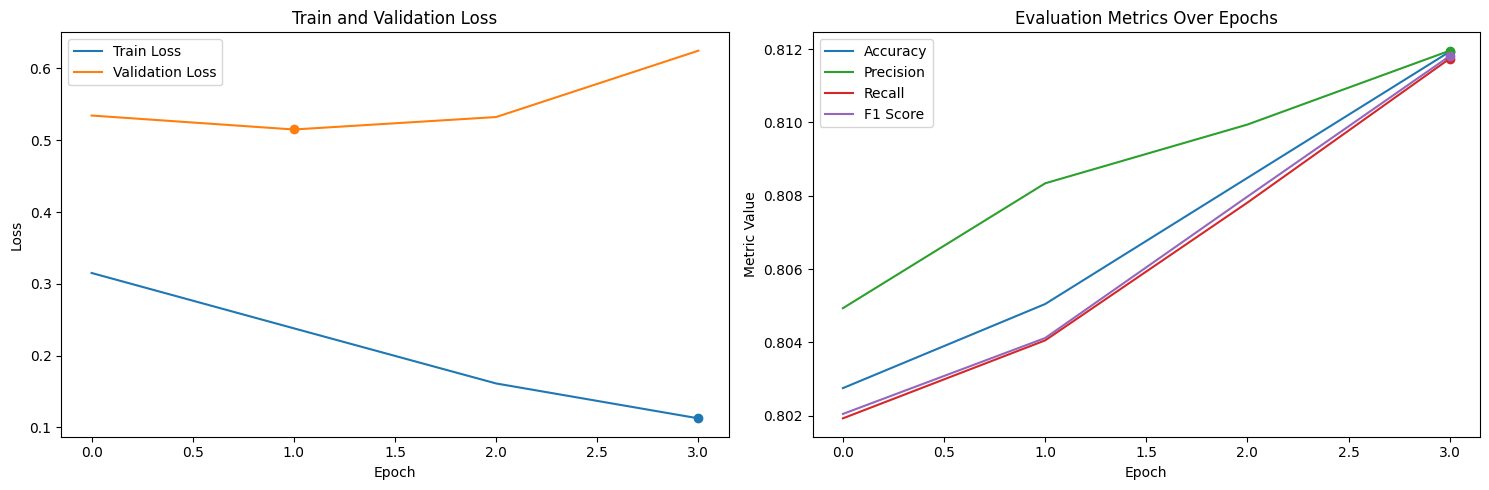

In [39]:
plot_train_eval_metrics(pruned_opt_distillation_trainer, all_metrics_pruned_opt_distillation)

#### Save and Load Pruned Model

In [40]:
pruned_model_opt_destillation_path = "./pruned_model_opt_destilled"

In [104]:
pruned_opt_distillation_trainer.save_model(pruned_model_opt_destillation_path)

In [41]:
pruned_opt_distilled_model = load_local_model(pruned_model_opt_destillation_path)

#### Train Tiny-BERT

In [42]:
best_run_tiny_bert = tiny_bert_distilled_trainer_exploration.hyperparameter_search(
    n_trials=n_trials,
    direction=direction,
    hp_space=hp_space
)
print(best_run_tiny_bert)

[I 2025-01-02 23:33:57,274] A new study created in memory with name: no-name-b62b43ff-29da-4737-9685-f65528b1873c


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.215100,0.532544,0.829128,0.829277,0.829345,0.829126
2,0.168500,0.549440,0.814220,0.815486,0.814789,0.814172
3,0.139500,0.651845,0.814220,0.814153,0.814200,0.814172
4,0.117800,0.666576,0.815367,0.815348,0.815452,0.815347
5,0.105700,0.722811,0.811927,0.811954,0.811737,0.811807


[I 2025-01-02 23:38:35,294] Trial 0 finished with value: 3.2474240526274274 and parameters: {'num_train_epochs': 5, 'learning_rate': 0.0001427921954325438, 'alpha': 0.3683566969544553, 'temperature': 7}. Best is trial 0 with value: 3.2474240526274274.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.207600,0.522236,0.824541,0.824869,0.824840,0.824541
2,0.177900,0.522227,0.826835,0.827164,0.827134,0.826835
3,0.157500,0.608515,0.813073,0.813301,0.813326,0.813073
4,0.140700,0.603262,0.823394,0.823506,0.823588,0.823391
5,0.130100,0.653379,0.813073,0.813007,0.813031,0.813018
6,0.122400,0.662171,0.807339,0.807304,0.807401,0.807314
7,0.115300,0.696194,0.805046,0.805066,0.804854,0.804922


[I 2025-01-02 23:44:53,299] Trial 1 finished with value: 3.2198873152412046 and parameters: {'num_train_epochs': 7, 'learning_rate': 7.440256465527338e-05, 'alpha': 0.9726989082637509, 'temperature': 6}. Best is trial 0 with value: 3.2474240526274274.


BestRun(run_id='0', objective=3.2474240526274274, hyperparameters={'num_train_epochs': 5, 'learning_rate': 0.0001427921954325438, 'alpha': 0.3683566969544553, 'temperature': 7}, run_summary=None)


In [43]:
for k,v in best_run_tiny_bert.hyperparameters.items():
    setattr(training_args, k, v)

tiny_bert_opt_distilliation_trainer = DistillationTrainer(
    tiny_bert_distilled_model,
    training_args,
    teacher_model=teacher_model,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/mv/96db_j8j3ng3t9pc8jczncdh0000gn/T/ipykernel_1316/239319299.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [44]:
all_metrics = []

tiny_bert_opt_distilliation_trainer.train()

all_metrics_tiny_bert_opt_distillation = all_metrics

all_metrics = []

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.215700,0.451439,0.832569,0.832506,0.832555,0.832526
2,0.168000,0.540425,0.814220,0.817342,0.813274,0.813395
3,0.139200,0.604214,0.799312,0.799351,0.799097,0.799172
4,0.118600,0.687524,0.805046,0.805417,0.805359,0.805045
5,0.105800,0.714811,0.807339,0.807320,0.807190,0.807238


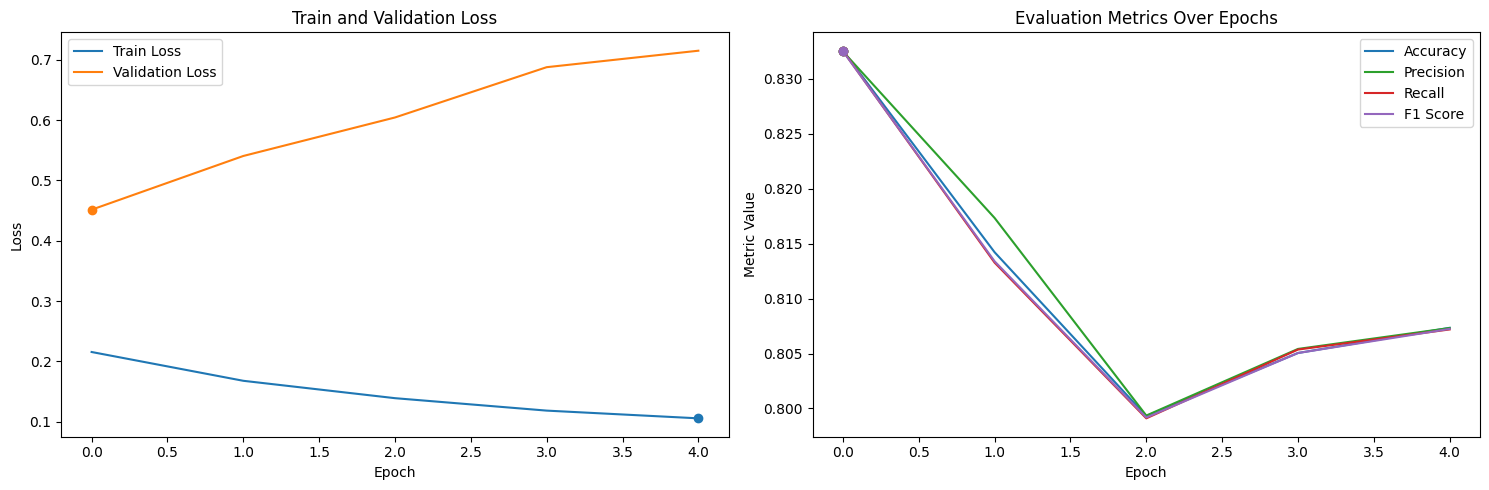

In [45]:
plot_train_eval_metrics(tiny_bert_opt_distilliation_trainer, all_metrics_tiny_bert_opt_distillation)

#### Save and Load Tiny-BERT

In [46]:
tiny_bert_model_opt_destillation_path = "./tiny_bert_model_opt_destilled"

In [95]:
tiny_bert_opt_distilliation_trainer.save_model(tiny_bert_model_opt_destillation_path)

No files have been modified since last commit. Skipping to prevent empty commit.


In [47]:
tiny_bert_opt_distilled_model = load_local_model(tiny_bert_model_opt_destillation_path)

# Evaluation

Make sure, that all models are loaded.

In [14]:
pruned_model_trained_path = "./pruned_model_trained"
tiny_bert_model_trained_path = "./tiny_bert_model_trained"
pruned_distilled_model_path = "./pruned_distilled_model"
tiny_bert_distilled_model_path = "./tiny_bert_distilled_model"
pruned_model_opt_destillation_path = "./pruned_model_opt_destilled"
tiny_bert_model_opt_destillation_path = "./tiny_bert_model_opt_destilled"
teacher_model_path = "./teacher_model"

pruned_model_trained = load_local_model(pruned_model_trained_path)
pruned_distilled_model = load_local_model(pruned_distilled_model_path)
pruned_opt_distilled_model = load_local_model(pruned_model_opt_destillation_path)
tiny_bert_model_trained = load_local_model(tiny_bert_model_trained_path)
tiny_bert_distilled_model = load_local_model(tiny_bert_distilled_model_path)
tiny_bert_opt_distilled_model = load_local_model(tiny_bert_model_opt_destillation_path)
teacher_model=load_local_model(teacher_model_path)

## Compare Model Parameters

In [17]:
import torch
import torch.nn as nn
import pandas as pd
from IPython.display import display, HTML

# Function to get model parameters
def get_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# Initialize models
models = {
    "Pruned Model": pruned_distilled_model,
    "Tiny BERT": tiny_bert_distilled_model,
    "BERT": teacher_model,
}

# Collect the model parameters
model_data = []
for model_name, model in models.items():
    total_params = get_model_parameters(model)
    model_data.append({"Model Name": model_name, "Total Parameters": total_params})

# Convert to DataFrame
df = pd.DataFrame(model_data)

# Calculate the percentage of the largest model's parameters
max_params = df["Total Parameters"].max()
df["Percentage of Max Model"] = (df["Total Parameters"] / max_params) * 100

# Sort the DataFrame by total parameters (optional)
df_sorted = df.sort_values(by="Total Parameters", ascending=False)

# Create HTML table structure
html_table = '<table border="1" style="border-collapse: collapse;">'

# Add header row
html_table += '<thead><tr><th style="padding: 5px; background-color: #f0f0f0; text-align: center;">Model Name</th>'
html_table += '<th style="padding: 5px; background-color: #f0f0f0; text-align: center;">Total Parameters</th>'
html_table += '<th style="padding: 5px; background-color: #f0f0f0; text-align: center;">Percentage of Biggest Model</th></tr></thead><tbody>'

# Add rows for each model
for index, row in df_sorted.iterrows():
    html_table += f'<tr><td style="padding: 5px; text-align: left;">{row["Model Name"]}</td>'
    html_table += f'<td style="padding: 5px; text-align: right;">{row["Total Parameters"]}</td>'
    html_table += f'<td style="padding: 5px; text-align: right;">{row["Percentage of Max Model"]:.2f}%</td>'

# Close the table
html_table += '</tbody></table>'

# Display the table
display(HTML(html_table))

Model Name,Total Parameters,Percentage of Biggest Model
BERT,109483778,100.00%
Pruned Model,33360770,30.47%
Tiny BERT,4386178,4.01%


## Calculate Metrics for All Models

In [16]:
val_data = tokenized_datasets["validation"]

# Run all models on cpu for comparability
pruned_model_trained.config.id2label = {0: 'negative', 1: 'positive'}
pruned_model_trained.config.label2id = {'negative': 0, 'positive': 1}
pruned_model_trained = pruned_model_trained.to("cpu")
pruned_distilled_model = pruned_distilled_model.to("cpu")
pruned_opt_distilled_model = pruned_opt_distilled_model.to("cpu")
tiny_bert_model_trained = tiny_bert_model_trained.to("cpu")
tiny_bert_distilled_model = tiny_bert_distilled_model.to("cpu")
tiny_bert_opt_distilled_model = tiny_bert_opt_distilled_model.to("cpu")
teacher_model = teacher_model.to("cpu")

pruned_model_eval = evaluate_model(pruned_model_trained, tokenizer, val_data)
pruned_distilled_model_eval = evaluate_model(pruned_distilled_model, tokenizer, val_data)
pruned_opt_distilled_model_eval = evaluate_model(pruned_opt_distilled_model, tokenizer, val_data)

tiny_bert_model_trained.config.id2label = {0: 'negative', 1: 'positive'}
tiny_bert_model_trained.config.label2id = {'negative': 0, 'positive': 1}
tiny_bert_model_eval = evaluate_model(tiny_bert_model_trained, tokenizer, val_data)
tiny_bert_distilled_model_eval = evaluate_model(tiny_bert_distilled_model, tokenizer, val_data)
tiny_bert_opt_distilled_model_eval = evaluate_model(tiny_bert_opt_distilled_model, tokenizer, val_data)

teacher_model.config.id2label = {0: 'negative', 1: 'positive'}
teacher_model.config.label2id = {'negative': 0, 'positive': 1}
teacher_model_eval = evaluate_model(teacher_model, tokenizer, val_data)

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


# Visualize Results

In [12]:
from IPython.display import display, HTML
from torch.utils.data import DataLoader

model_results = {
    'Pruned': pruned_model_eval,
    'Pruned + Disitilled': pruned_distilled_model_eval,
    'Pruned + optuna Distilled': pruned_opt_distilled_model_eval,
    'Tiny BERT': tiny_bert_model_eval,
    'Tiny BERT + Distilled': tiny_bert_distilled_model_eval,
    'Tiny BERT + optuna Distilled': tiny_bert_opt_distilled_model_eval,
    'BERT': teacher_model_eval
}

# Create HTML table structure
html_table = '<table border="1" style="border-collapse: collapse;">'

# Add header row
html_table += '<thead><tr><th style="padding: 10px; background-color: #d3d3d3; text-align: center; border: 1px solid black;">Metric</th>'
for model_name in model_results.keys():
    html_table += f'<th style="padding: 10px; background-color: #d3d3d3; text-align: center; border: 1px solid black;">{model_name}</th>'
html_table += '</tr></thead><tbody>'

# Add rows for each metric
metrics = list(next(iter(model_results.values())).keys())  # Extract metric names
for metric in metrics:
    html_table += f'<tr><td style="text-align: left; border: 1px solid black;">{metric}</td>'
    for model_name in model_results.keys():
        value = round(model_results[model_name][metric], 4)
        html_table += f'<td style="text-align: right; border: 1px solid black;">{value}</td>'
    html_table += '</tr>'

# Close the table
html_table += '</tbody></table>'

# Display the table
display(HTML(html_table))


Metric,Pruned,Pruned + Disitilled,Pruned + optuna Distilled,Tiny BERT,Tiny BERT + Distilled,Tiny BERT + optuna Distilled,BERT
accuracy,0.8211,0.828,0.8245,0.8314,0.8303,0.8349,0.9243
total_time_in_seconds,7.3904,7.357,7.262,0.5782,0.6373,0.6318,21.4963
samples_per_second,117.9909,118.5271,120.0769,1508.1948,1368.2355,1380.1891,40.5651
latency_in_seconds,0.0085,0.0084,0.0083,0.0007,0.0007,0.0007,0.0247


# Compare Performance on Test Prompts

In [13]:
# HTML, because I could'nt find a good package that has colspan functionality
from transformers import pipeline
import torch
from IPython.display import display, HTML

# List of Prompts
prompts = [
    "This movie was amazing!",
    "I hated the ending.",
    "The acting was mediocre.",
    "It was an okay film.",
    "A truly captivating experience!",
    "The movie wasn't good. It was great!"
]

models = [
    {"model": pruned_model_trained, "tokenizer": tokenizer, "label": "Pruned"},
    {"model": pruned_distilled_model, "tokenizer": tokenizer, "label": "Pruned + Distilled"},
    {"model": pruned_opt_distilled_model, "tokenizer": tokenizer, "label": "Pruned + optuna Distilled"},
    {"model": tiny_bert_model_trained, "tokenizer": tokenizer, "label": "Tiny BERT"},
    {"model": tiny_bert_distilled_model, "tokenizer": tokenizer, "label": "Tiny BERT + Distilled"},
    {"model": tiny_bert_opt_distilled_model, "tokenizer": tokenizer, "label": "Tiny BERT + optuna Distilled"},
    {"model": teacher_model, "tokenizer": tokenizer, "label": "BERT"}
]

# Initialize the classifier pipelines for each model
device = torch.device("cpu")

# Use 'pipeline' properly to initialize each model's text classification pipeline
pipelines = [
    pipeline("text-classification", model=model_info["model"], tokenizer=model_info["tokenizer"], device=-1)
    for model_info in models
]

# Create the HTML table structure for model results
model_results_html = '<table border="1" style="border-collapse: collapse;">'  # Table with borders collapsed

model_results_html += '<thead><tr><th  style="border: 1px solid black;background-color: #d3d3d3"></th>'  # First header cell

# Add headers for each model's label and score, with borders
for model in models:
    model_results_html += f'<th colspan="2" style="border: 1px solid black; text-align: center;background-color: #d3d3d3">{model["label"]}</th>'
model_results_html += '</tr><tr>'

model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Prompt</th>'  # Prompt header cell

# Add "Label" and "Score" headers for each model, with borders
for model in models:
    model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Label</th>'
    model_results_html += '<th style="border: 1px solid black;text-align: center;background-color: #d3d3d3">Score</th>'
model_results_html += '</tr></thead><tbody>'

# Process each prompt for all models and add to the HTML table
for prompt in prompts:
    model_results_html += f'<tr><td style="border: 1px solid black;text-align: left">{prompt}</td>'  # Add borders for the Prompt cell
    
    for pipeline in pipelines:
        result = pipeline(prompt)[0]
        label = result['label']
        
        # Map the label to 1 (positive) or 0 (negative)
        if label == "positive":
            label = "1"  # Convert to string
        elif label == "negative":
            label = "0"  # Convert to string
        
        score = f"{result['score']:.4f}"
        model_results_html += f'<td style="border: 1px solid black;text-align: center">{label}</td>'  # Add borders for the Label column
        model_results_html += f'<td style="border: 1px solid black;text-align: center">{score}</td>'  # Add borders for the Score column
    
    model_results_html += '</tr>'

# Close the table tag
model_results_html += '</tbody></table>'

# Display the final HTML table with only model results
display(HTML(model_results_html))

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu
